# 1. Data exploration

The aim of this notebook is to do some data exploration on our dataset in order to better understand it and take notes on some details before further data processing or data generation. We mainly focused on the road caracteristics, the speed, weight and types of cars and the date of events, as suggested by our host from the lab TRANSP-OR. 

Further data exploration specifically for the discrete event generation is also included in the notebook 5-discrete-event-generation.ipynb

## Setup

### Useful imports

In [3]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['axes.grid'] = False

### Data loading

#### Load dataset and rename columns to understandable formats

In [45]:
DATA_PATH = "../data/405.txt"

cols_map = {
    "DTS": "crossTime",
    "LANE": "lane",
    "DIR": "direction",
    "SPEED": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
    "Year": "year",
    "Month": "month",
    "Day" : "day",
}

columns = list(cols_map.values())

df = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
df.rename(columns=cols_map, inplace=True)

df.head()

,crossTime,lane,direction,speed,nAxles,weight,type,year,month,day
0,2011-04-01 00:41:31.40,2,1,106,2,15980,11,2011,4,1
1,2011-04-01 00:42:10.50,2,1,116,2,3630,11,2011,4,1
2,2011-04-01 00:47:15.70,2,1,84,4,18480,1111,2011,4,1
3,2011-04-01 01:23:37.20,2,1,88,2,11050,11,2011,4,1
4,2011-04-01 01:33:23.40,2,1,89,5,30330,113,2011,4,1


Convert the 'crossTime' feature as datetime type

In [46]:
df['crossTime'] = pd.to_datetime(df['crossTime'])
df.head()

,crossTime,lane,direction,speed,nAxles,weight,type,year,month,day
0,2011-04-01 00:41:31.400,2,1,106,2,15980,11,2011,4,1
1,2011-04-01 00:42:10.500,2,1,116,2,3630,11,2011,4,1
2,2011-04-01 00:47:15.700,2,1,84,4,18480,1111,2011,4,1
3,2011-04-01 01:23:37.200,2,1,88,2,11050,11,2011,4,1
4,2011-04-01 01:33:23.400,2,1,89,5,30330,113,2011,4,1


Check to see if there is any invalid data

In [47]:
df.isna().sum()

crossTime    0
lane         0
direction    0
speed        0
nAxles       0
weight       0
type         0
year         0
month        0
day          0
dtype: int64

Convert the features "type" and "lane" into categorical types

In [10]:
df['type'] = df.type.astype('category')
df['lane'] = df.lane.astype('category')

### Initial data exploration

Find the date range of our data

In [11]:
mn, mx = df.crossTime.min(), df.crossTime.max()
print(f"Our data ranges from {mn} to {mx}, ranging a period of {mx - mn}")

Our data ranges from 2011-04-01 00:41:31.400000 to 2021-03-28 23:29:14.400000, ranging a period of 3649 days 22:47:43


Compute summary statistics

In [48]:
df.describe()

,lane,direction,speed,nAxles,weight,type,year,month,day
count,4.841075e+06,4841075.0,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06
mean,1.635797e+00,1.0,8.586481e+01,3.491157e+00,1.660369e+04,5.206801e+02,2.016032e+03,6.489607e+00,1.576537e+01
std,4.812061e-01,0.0,9.172992e+00,1.232331e+00,1.084427e+04,1.765847e+05,2.988873e+00,3.348895e+00,8.665441e+00
min,1.000000e+00,1.0,0.000000e+00,2.000000e+00,3.500000e+03,2.000000e+00,2.011000e+03,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.0,8.300000e+01,2.000000e+00,7.720000e+03,1.100000e+01,2.013000e+03,4.000000e+00,8.000000e+00
50%,2.000000e+00,1.0,8.700000e+01,4.000000e+00,1.513000e+04,1.110000e+02,2.016000e+03,6.000000e+00,1.600000e+01
75%,2.000000e+00,1.0,8.900000e+01,4.000000e+00,2.138000e+04,1.130000e+02,2.019000e+03,9.000000e+00,2.300000e+01
max,2.000000e+00,1.0,2.550000e+02,9.000000e+00,9.994000e+04,1.111111e+08,2.021000e+03,1.200000e+01,3.100000e+01


From the summary statistics :
- The standard deviation of the direction is 0, meaning we can drop this column.
- The standard deviation of the lane is not exactly 0, meaning we have multiple lanes
- The minimum measured weight is 3500kg.

In [13]:
df.drop('direction', axis=1, inplace=True)

We will then further investigate the lane feature and the traffic on these lanes.

In [15]:
n_lanes = len(df['lane'].unique())
lane_1 = df[df['lane'].isin([1])]
lane_2 = df[df['lane'].isin([2])]
nType, nType_1, nType_2 = df.type.nunique(), lane_1.type.nunique(), lane_2.type.nunique()
print(f"There are {n_lanes} lanes. We have {nType} types of car in total, {nType_1} on lane 1 and {nType_2} on lane 2")

There are 2 lanes. We have 272 types of car in total, 193 on lane 1 and 255 on lane 2


Let's check the traffic on a month by resampling the data per hour

In [18]:
# Choose a specific period of time from the entire dataset. 
def choose_date(df, year=None, month=None, day=None, hour=None):
    specific_df = df.copy()
    if year != None:
        specific_df = specific_df[(specific_df.year == year)]
    if month != None:
        specific_df = specific_df[(specific_df.month == month)]
    if day != None:
        specific_df = specific_df[(specific_df.day == day)]
    if hour != None:
        specific_df = specific_df[(specific_df.hour == hour)]
    return specific_df

In [23]:
lane_1_2018_4 = choose_date(lane_1, year = 2018, month = 4)
lane_2_2018_4 = choose_date(lane_2, year = 2018, month = 4)
lane_1_2018_4.index = lane_1_2018_4['crossTime']
lane_2_2018_4.index = lane_2_2018_4['crossTime']

We plot the number of cars per hour on a month on each lane.

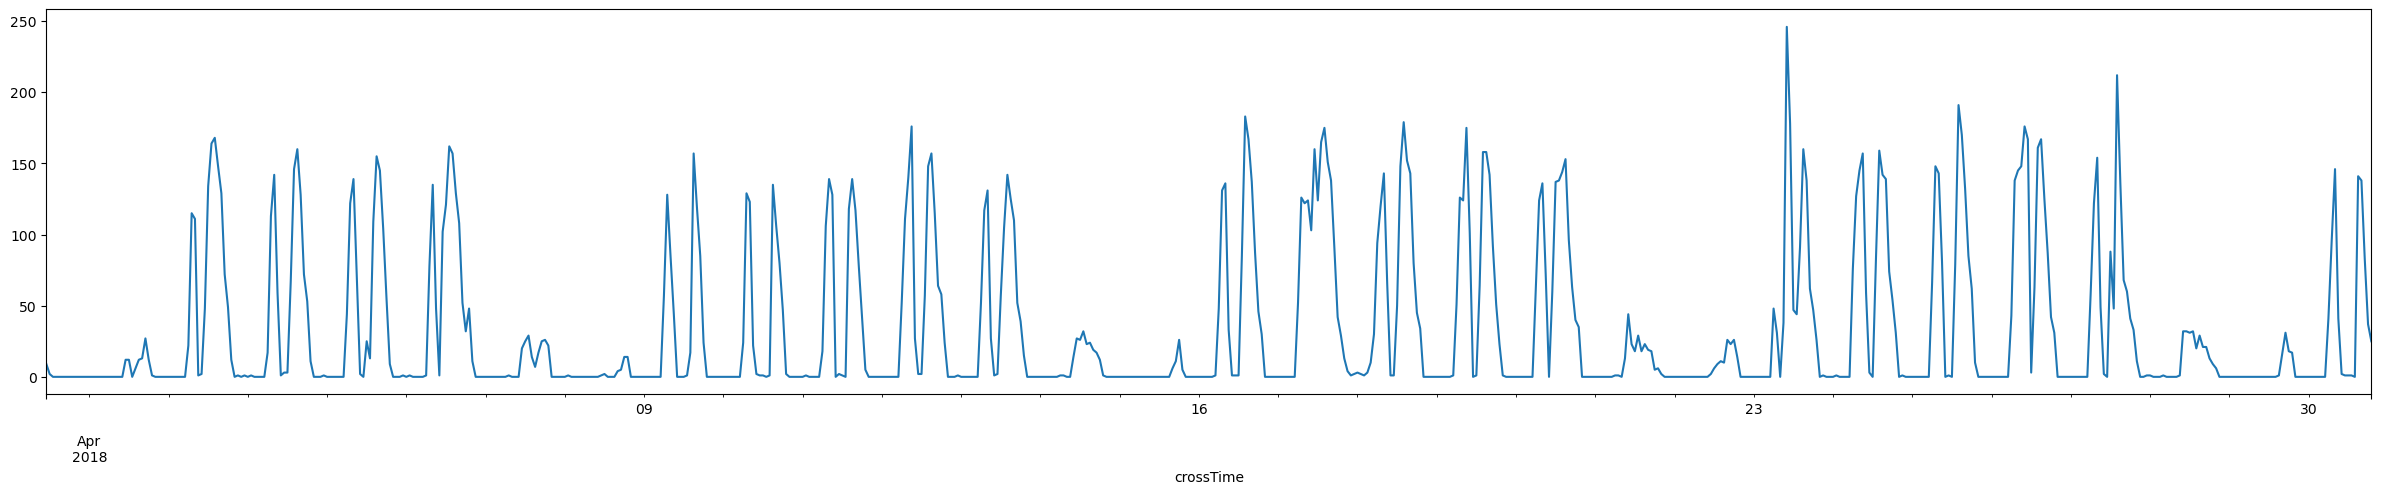

In [28]:
plt.figure(figsize=(30,5))
lane_1_2018_4['speed'].resample('1h').count().plot()
plt.show()

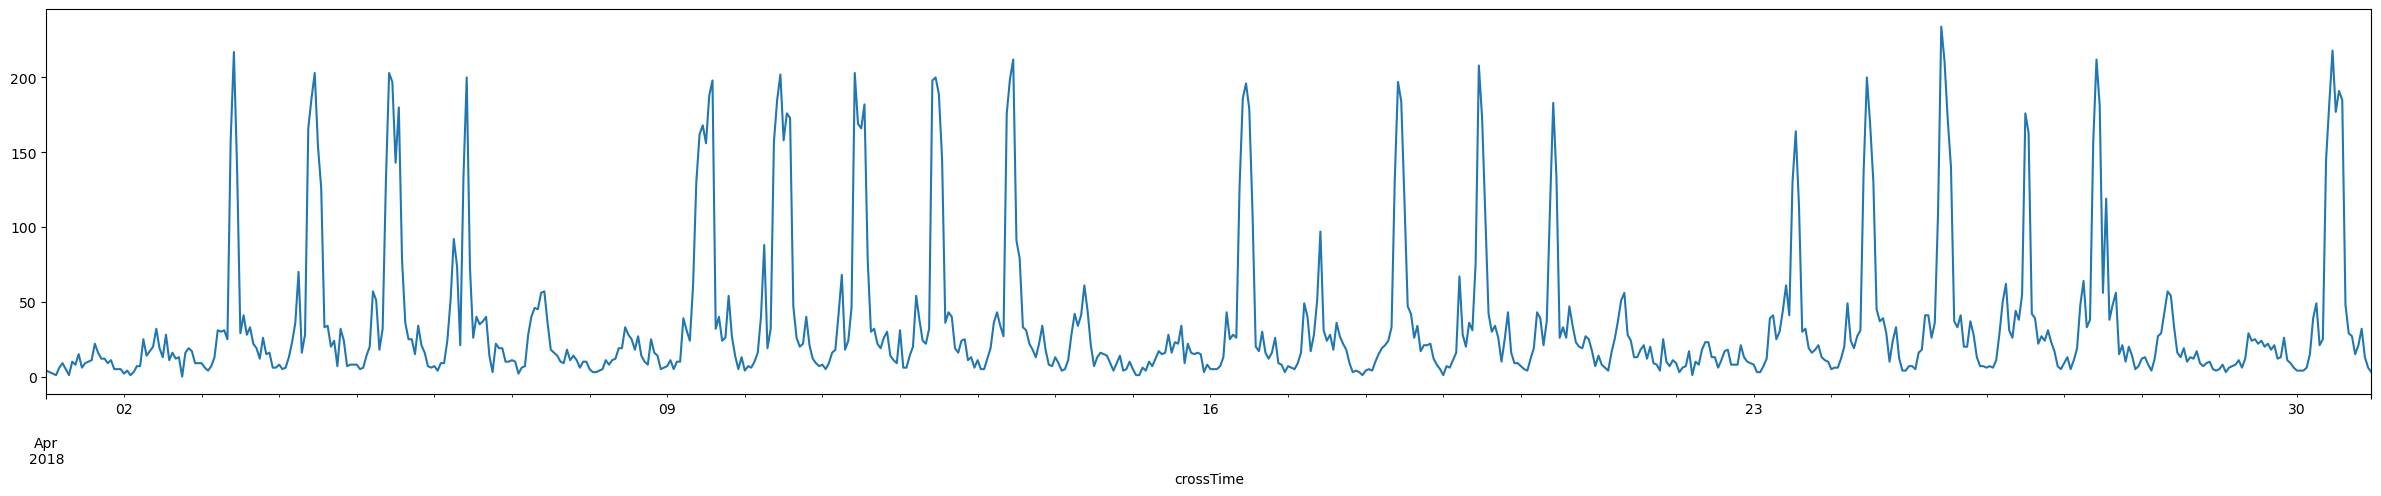

In [30]:
plt.figure(figsize=(30,5))
lane_2_2018_4['speed'].resample('1h').count().plot()
plt.show()

In conclusion, our road is composed of 2 lanes where cars drive in the same direction. Moreover, it seems that there is slighty more traffic on the lane 2 than the lane 1. As in Switzerland, usually one drives on the right lane and overtake the cars on the left lane, we can say that the lane 1 is the right lane and lane 2 the left lane.

### Explore other features such as speed, weight and nAxles

In [34]:
df_2018 = choose_date(df, year = 2018)
df_2018_4 = choose_date(df_2018, month = 4)
df_2018_4_10 = choose_date(df_2018_4, day = 10)
df_2018_4_week = df_2018_4.loc[(df_2018_4['day'] >= 9) & (df_2018_4['day'] <= 15)]

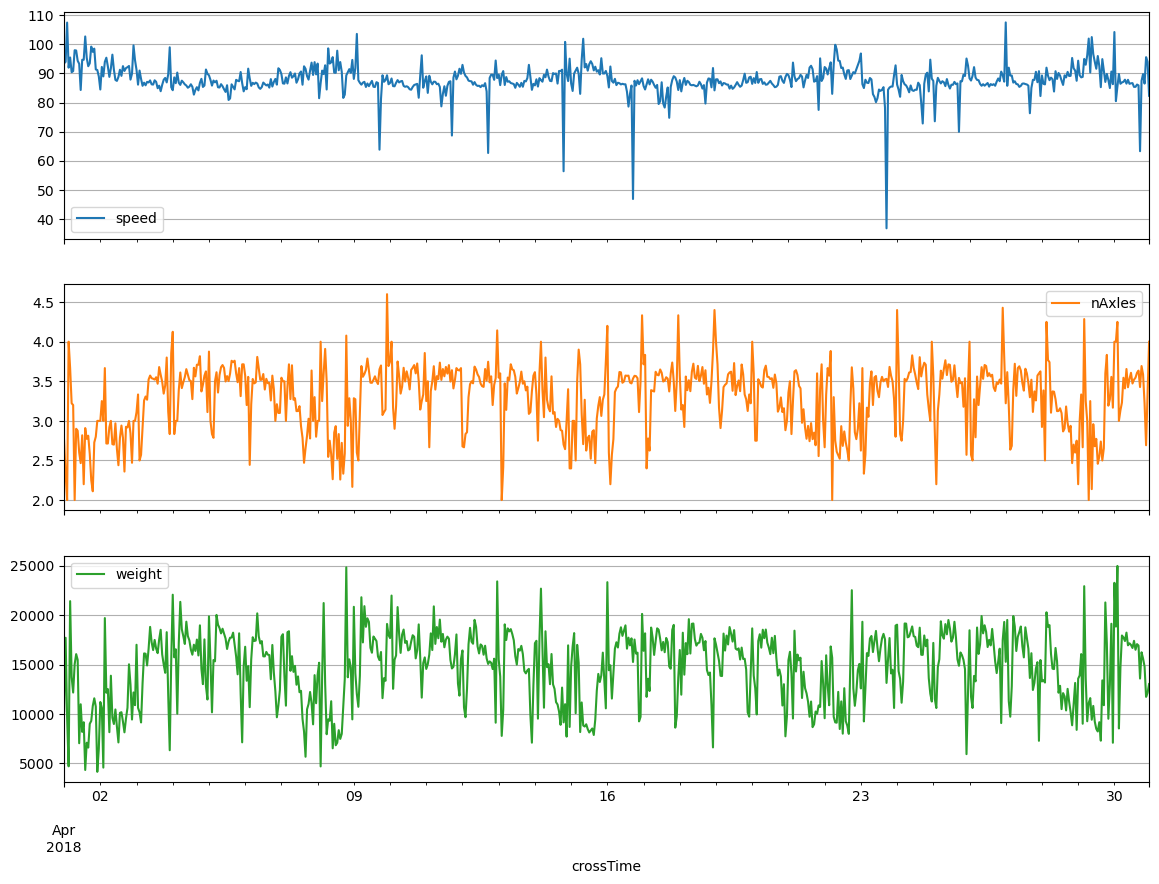

In [32]:
plot_features = df_2018_4.loc[:, ['speed', 'nAxles', 'weight']]
plot_features.index = df_2018_4['crossTime']
plot_features.resample('1h').mean().plot(subplots=True, grid=True)
plt.show()

We can see that the number of axles and the weight seems to be correlated, so we decide to drop the nAxles feature.

In [33]:
df.drop('nAxles', axis=1, inplace=True)
df_2018_4.drop('nAxles', axis=1, inplace=True)

We then plot the variation of weight and speed throughout a year, month, week and day

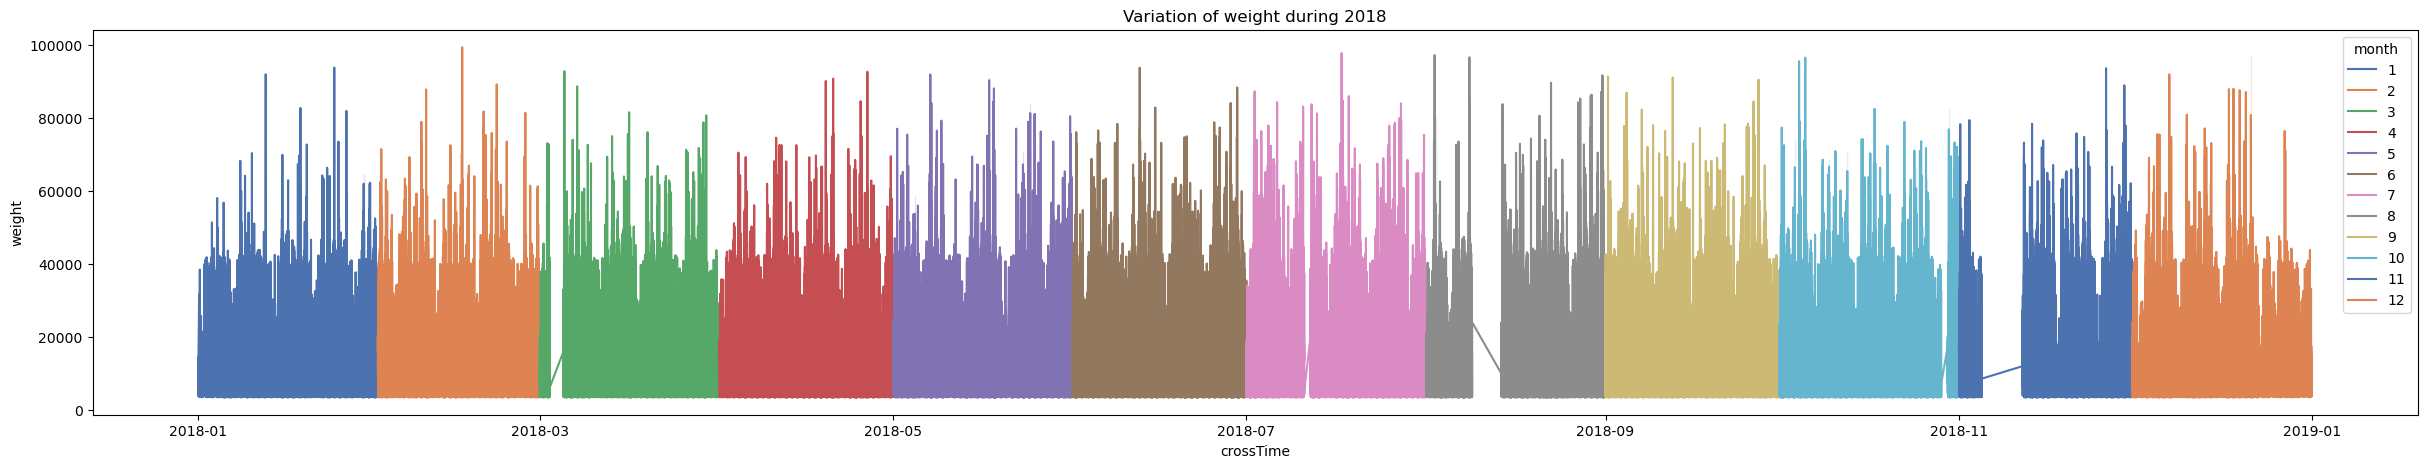

In [35]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during 2018')
sns.lineplot(x = df_2018.crossTime, y= df_2018.weight, hue=df_2018.month, palette="deep");
plt.show()

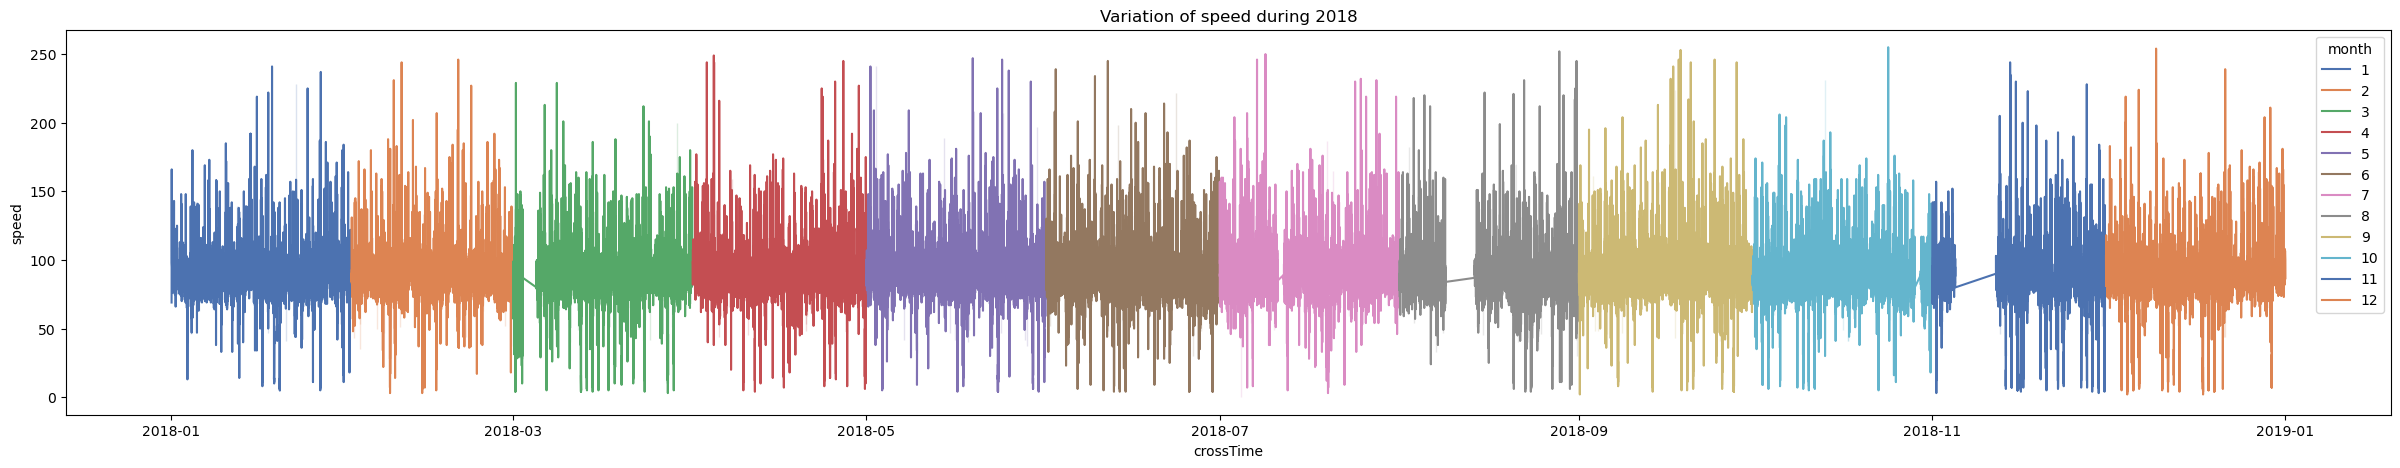

In [260]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 2018')
sns.lineplot(x = df_2018.crossTime, y= df_2018.speed, hue=df_2018.month, palette="deep");
plt.show()

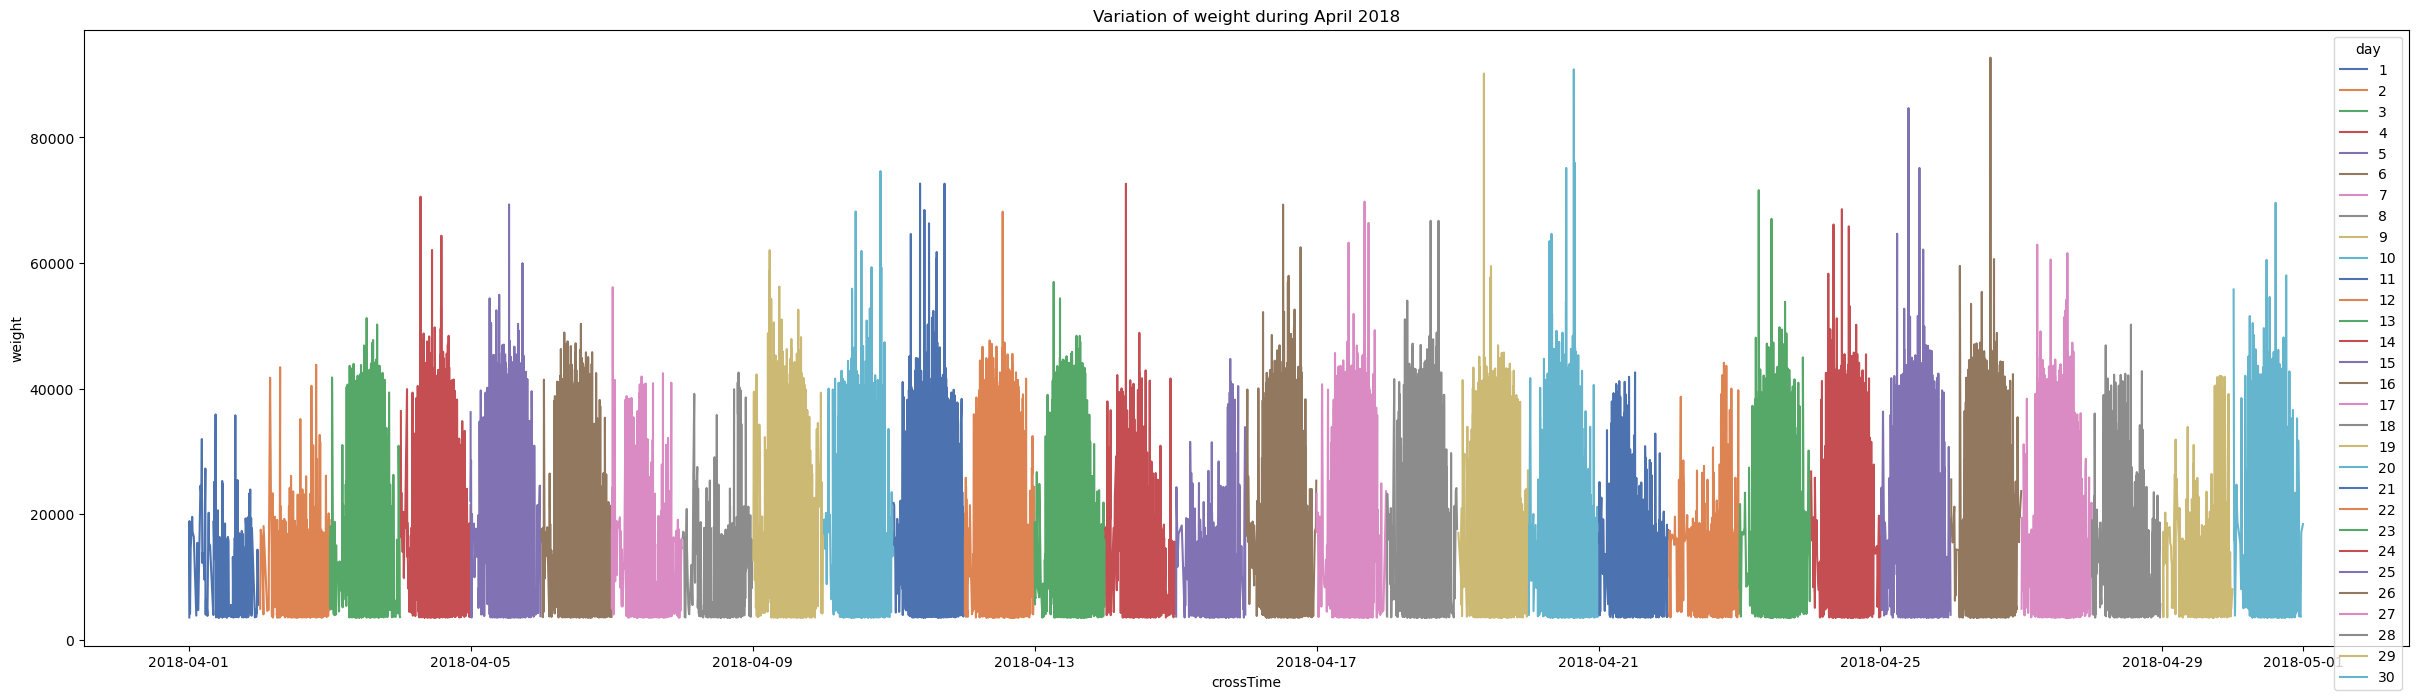

In [253]:
plt.figure(figsize=(30,8))
plt.title('Variation of weight during April 2018')
sns.lineplot(x = new_df_2018_4.crossTime, y= new_df_2018_4.weight, hue=new_df_2018_4.day, palette="deep");
plt.show()

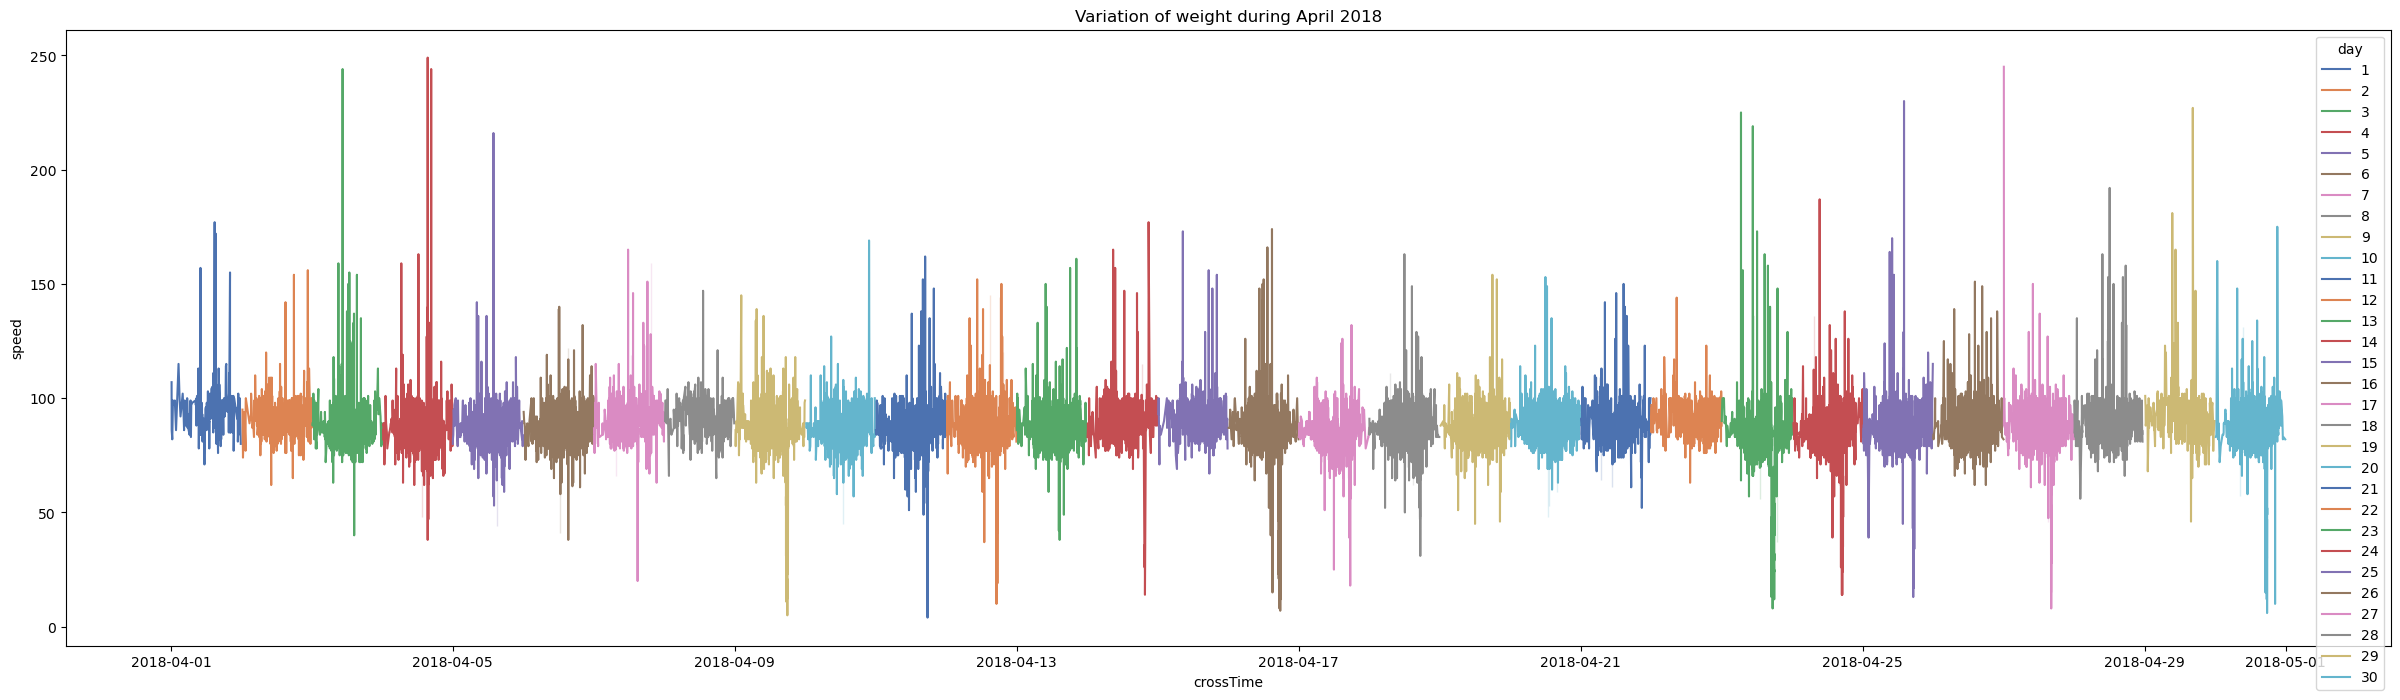

In [252]:
plt.figure(figsize=(30,8))
plt.title('Variation of speed during April 2018')
sns.lineplot(x = new_df_2018_4.crossTime, y= new_df_2018_4.speed, hue=new_df_2018_4.day, palette="deep");
plt.show()

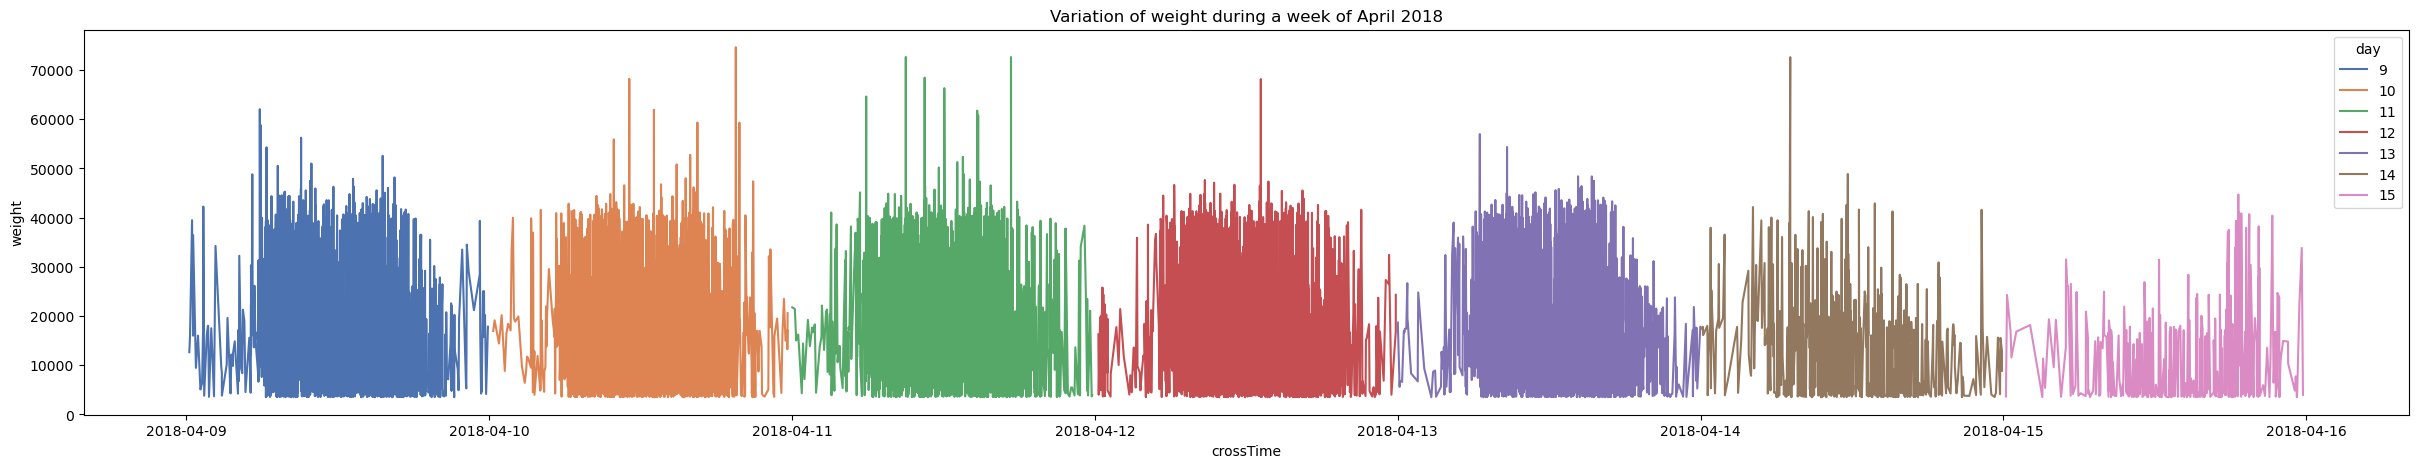

In [248]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during a week of April 2018')
sns.lineplot(x = new_df_2018_4_week.crossTime, y= new_df_2018_4_week.weight, hue=new_df_2018_4_week.day, palette="deep");
plt.show()

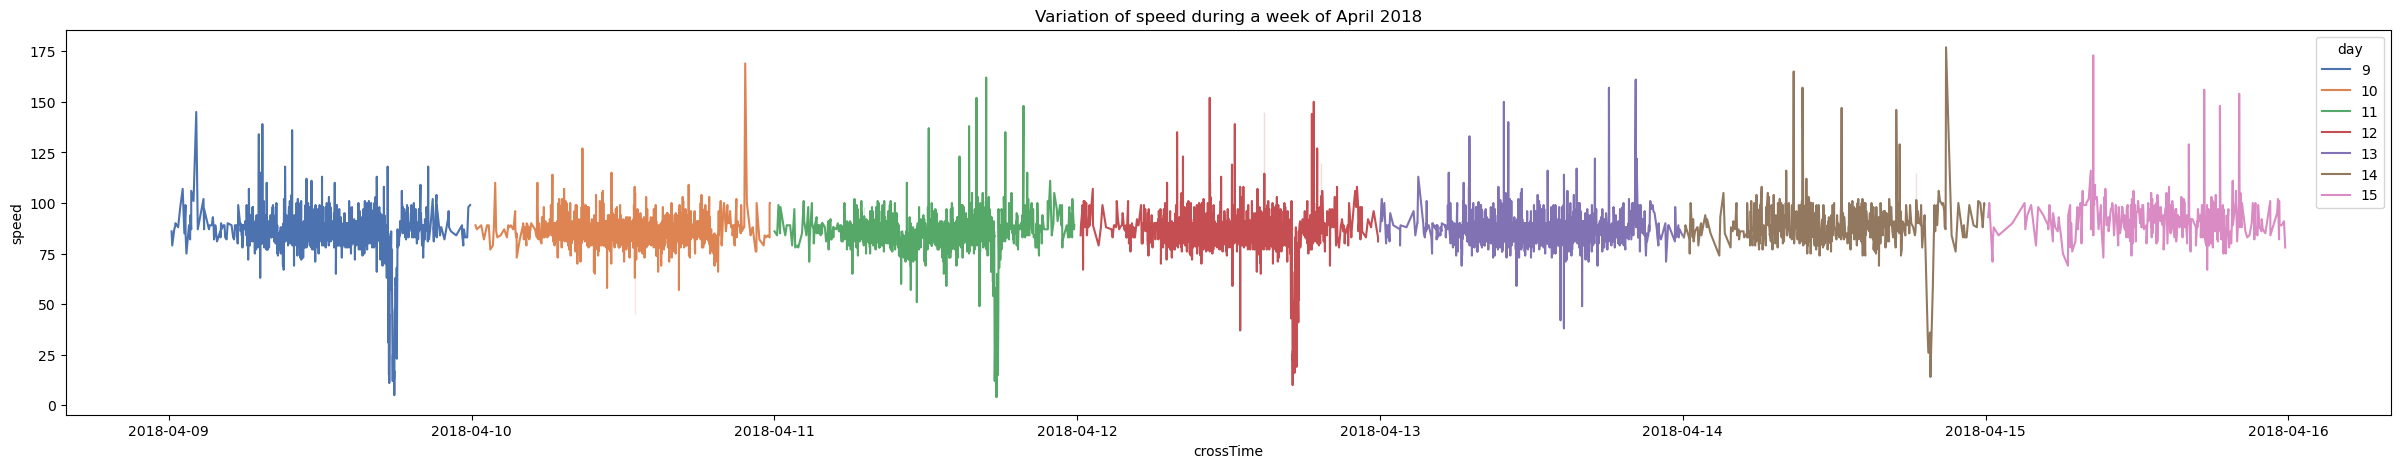

In [249]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during a week of April 2018')
sns.lineplot(x = new_df_2018_4_week.crossTime, y= new_df_2018_4_week.speed, hue=new_df_2018_4_week.day, palette="deep");
plt.show()

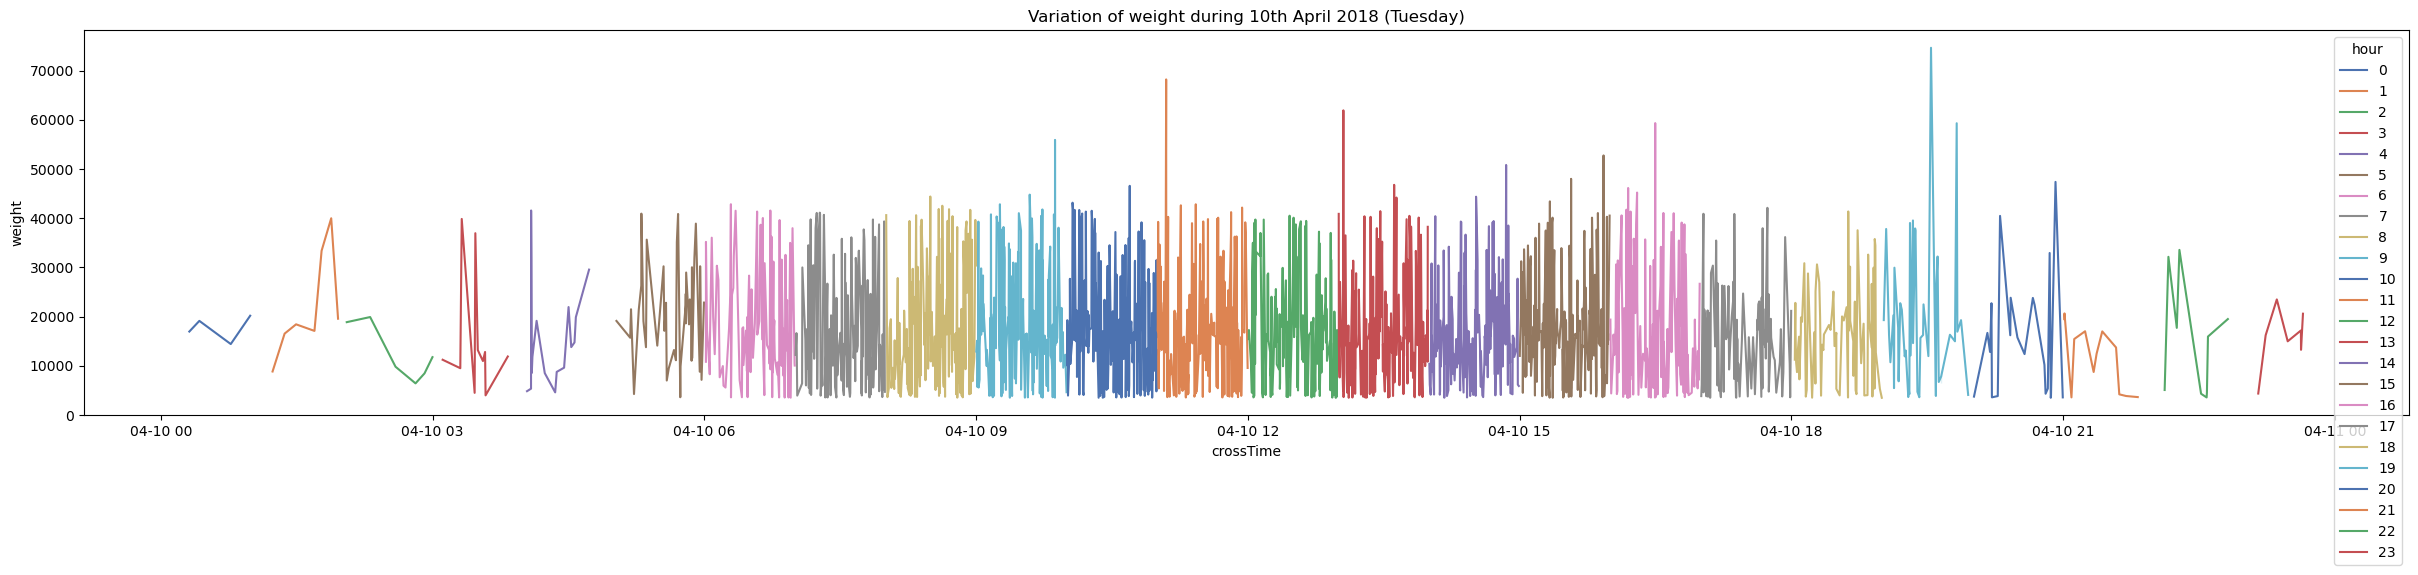

In [265]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during 10th April 2018 (Tuesday)')
sns.lineplot(x = new_df_2018_4_10.crossTime, y= new_df_2018_4_10.weight, hue=new_df_2018_4_10.hour, palette="deep");
plt.show()

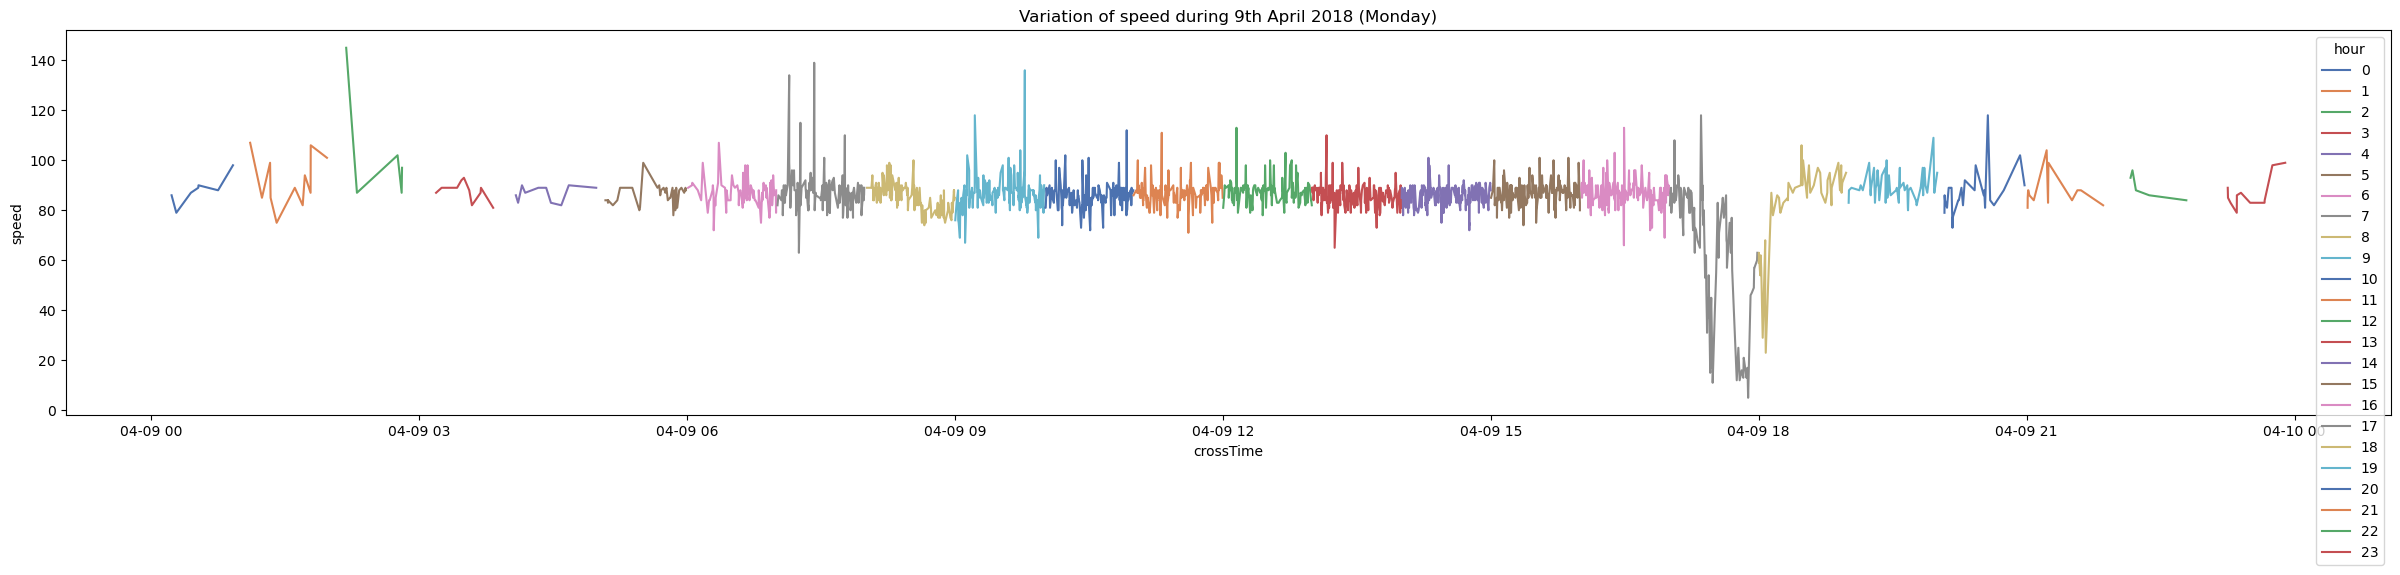

In [328]:
new_df_2018_4_9 = choose_date(new_df_2018_4, day = 9)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 9th April 2018 (Monday)')
sns.lineplot(x = new_df_2018_4_9.crossTime, y= new_df_2018_4_9.speed, hue=new_df_2018_4_9.hour, palette="deep");
plt.show()

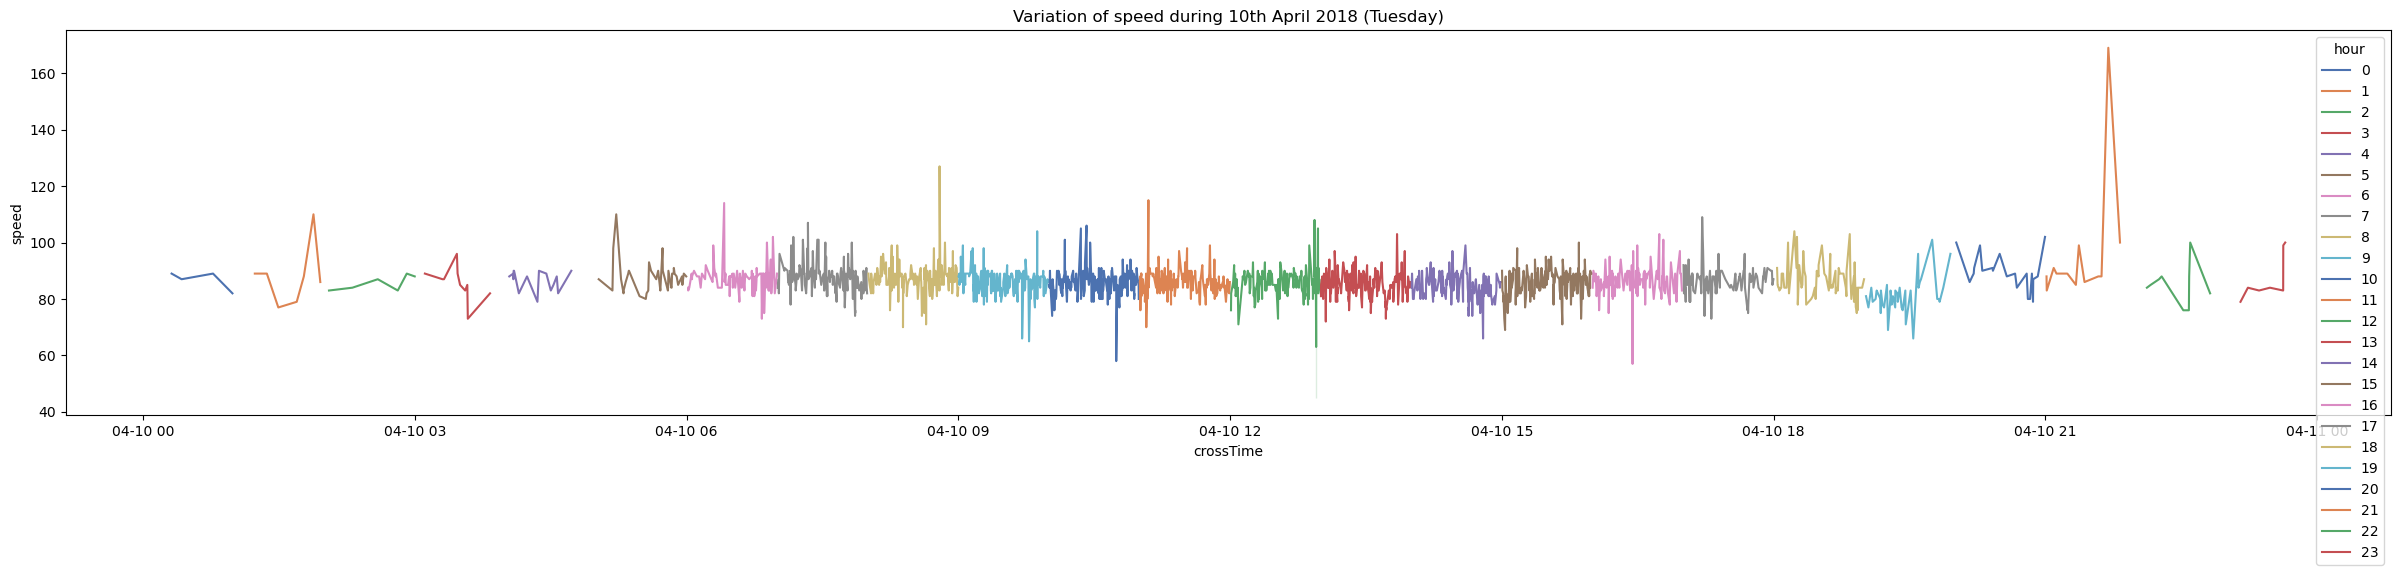

In [246]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 10th April 2018 (Tuesday)')
sns.lineplot(x = new_df_2018_4_10.crossTime, y= new_df_2018_4_10.speed, hue=new_df_2018_4_10.hour, palette="deep");
plt.show()

We also check speed variation throughout some days

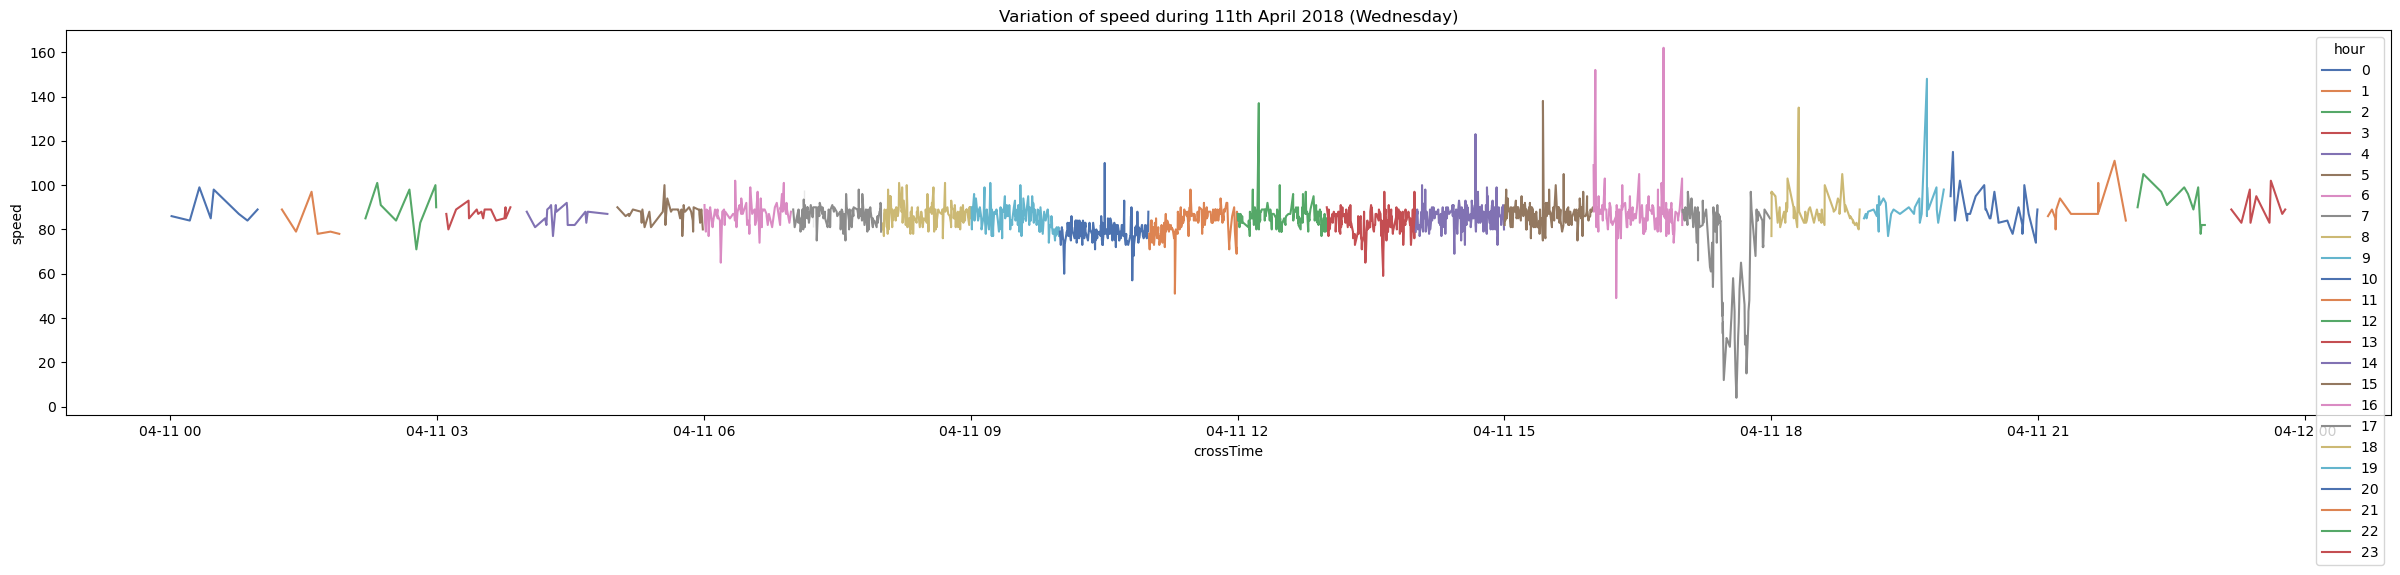

In [316]:
new_df_2018_4_11 = choose_date(new_df_2018_4, day = 11)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 11th April 2018 (Wednesday)')
sns.lineplot(x = new_df_2018_4_11.crossTime, y= new_df_2018_4_11.speed, hue=new_df_2018_4_11.hour, palette="deep");
plt.show()

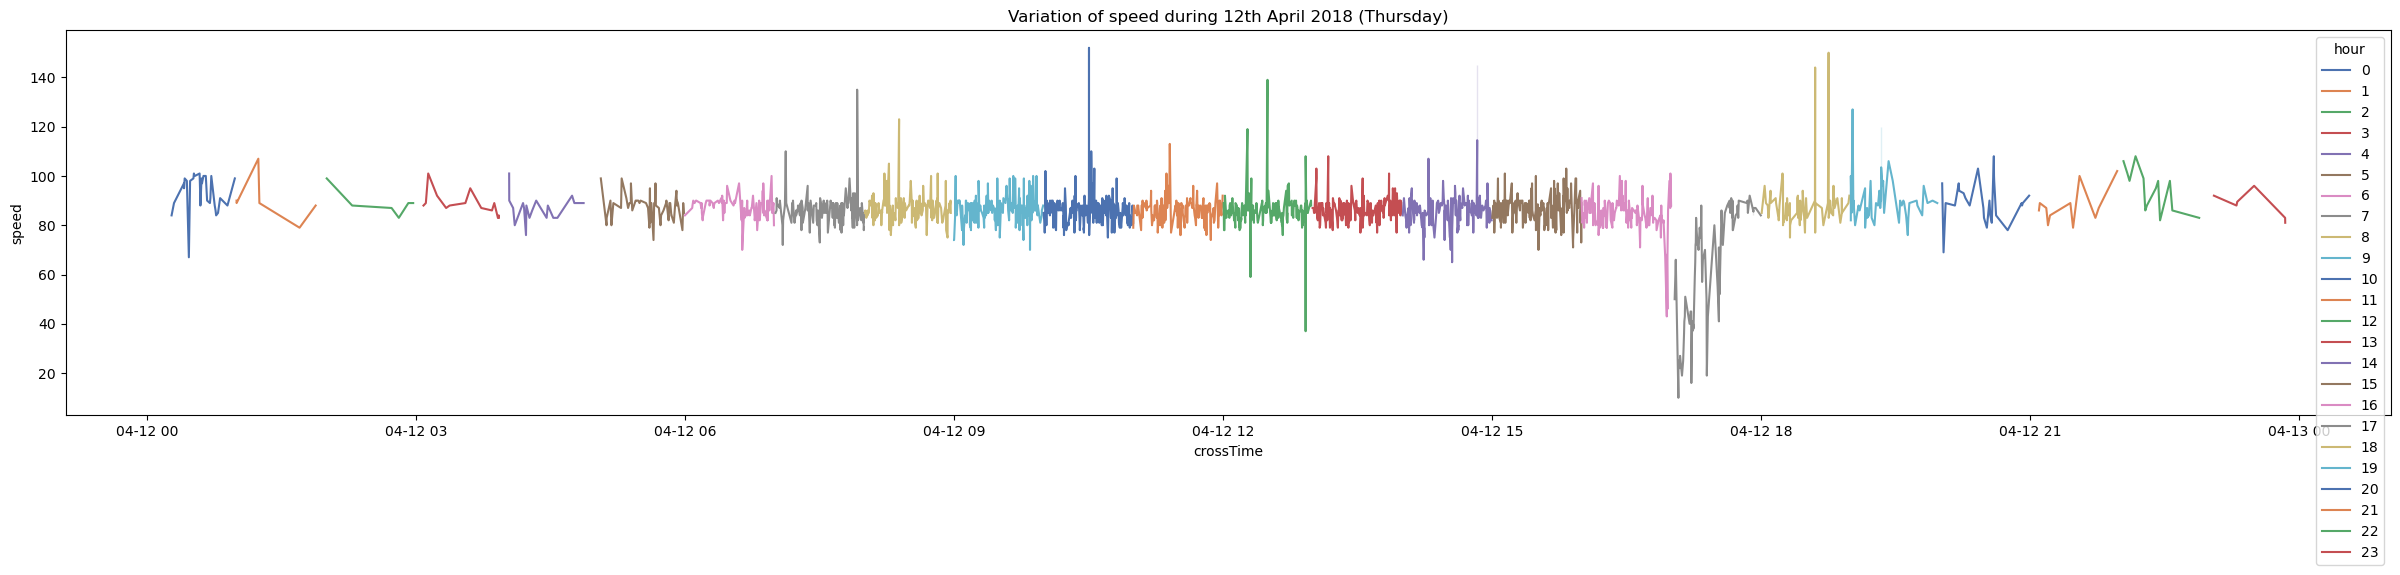

In [318]:
new_df_2018_4_12 = choose_date(new_df_2018_4, day = 12)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 12th April 2018 (Thursday)')
sns.lineplot(x = new_df_2018_4_12.crossTime, y= new_df_2018_4_12.speed, hue=new_df_2018_4_12.hour, palette="deep");
plt.show()

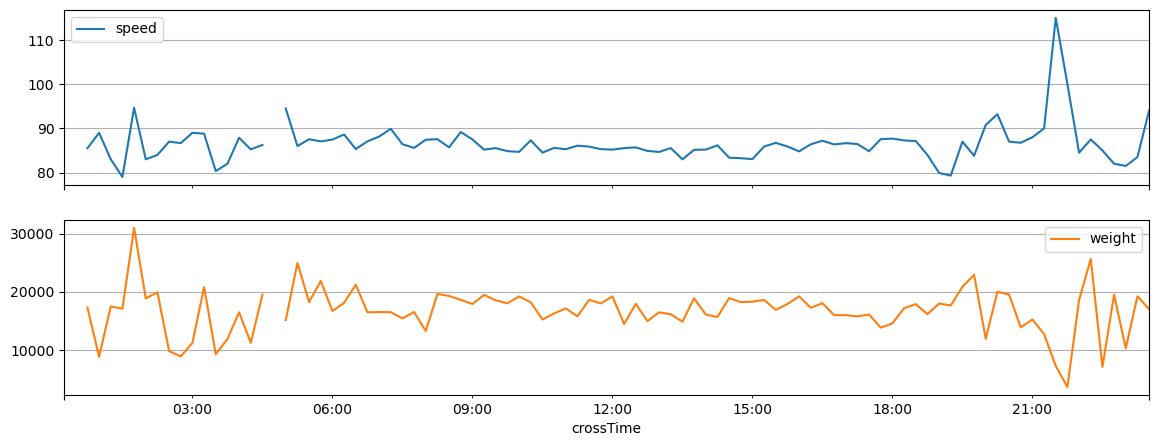

In [267]:
plot_features = new_df_2018_4_10.loc[:, ['speed', 'weight']]

plot_features.index = new_df_2018_4_10['crossTime']
plot_features.resample('15T').mean().plot(subplots=True, grid=True, figsize=(14, 5))
plt.show()

From a quick look, we see that there are some periods without data. Moreover, there are some cars that drives at a high speed (~250km/h) and other times the speed drops to 0, that could correspond to traffic jams.

It seems that there is some periodicity in the data. There is less traffic on the week-ends and during the night. The traffic jam seems to happen around 5pm. Moreover, the speed and the weight of the cars are quite constant from 6am to 5pm.

### Distribution of speed and weight

We check the speed and weight distribution in general

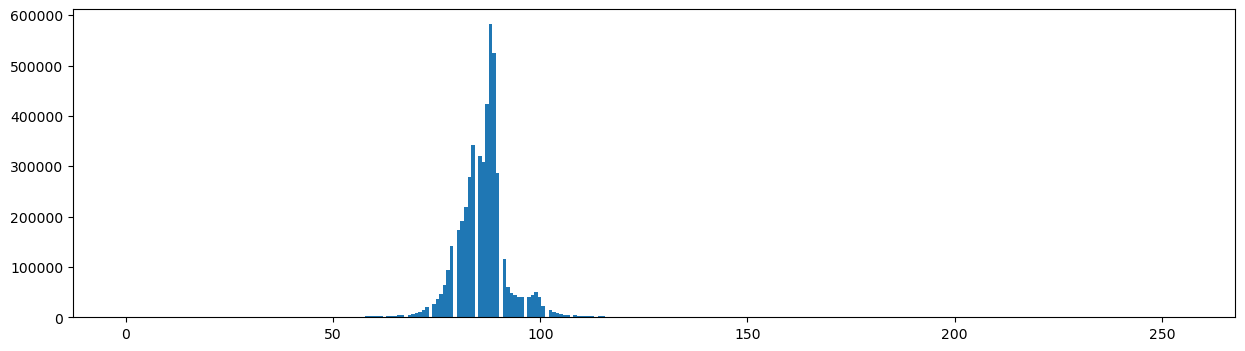

In [37]:
plt.figure(figsize=(15,4))
plt.hist(df.speed, bins = 300)
plt.show()

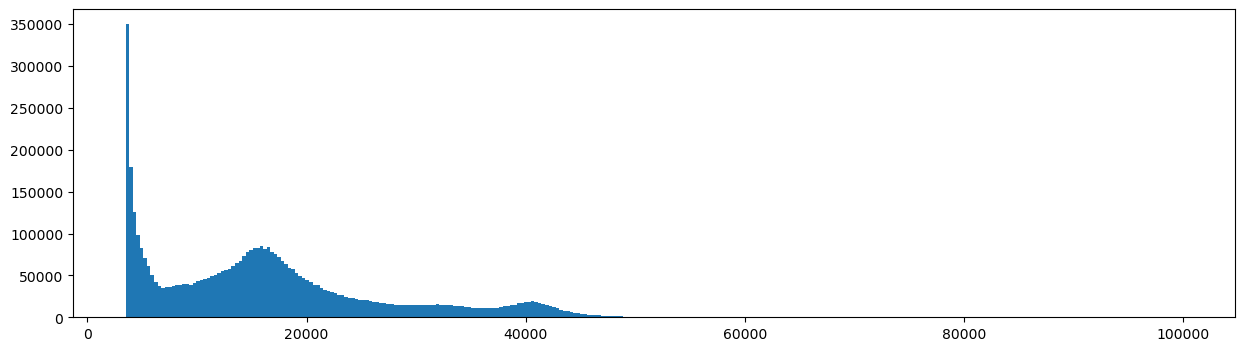

In [38]:
plt.figure(figsize=(15,4))
plt.hist(df.weight, bins = 300)
plt.show()

Then we are interested to know if the for every vehicules of same type, the weight is quite the same.

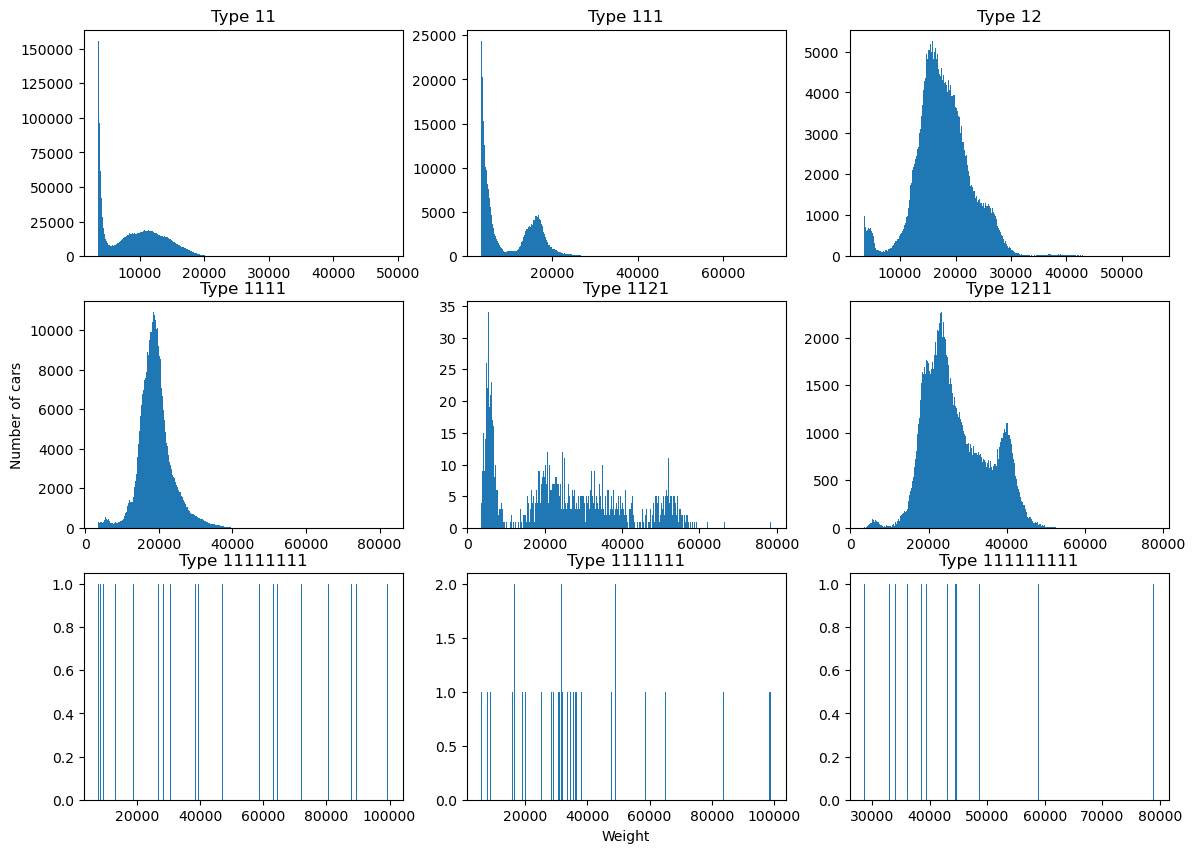

In [41]:
fig, axs = plt.subplots(3,3)
axs[0,0].hist(df.loc[df['type'] == 11].weight, bins = 300)
axs[0,0].set_title("Type 11")
axs[0,1].hist(df.loc[df['type'] == 111].weight, bins = 300)
axs[0,1].set_title("Type 111")
axs[0,2].hist(df.loc[df['type'] == 12].weight, bins = 300)
axs[0,2].set_title("Type 12")

axs[1,0].hist(df.loc[df['type'] == 1111].weight, bins = 300)
axs[1,0].set_title("Type 1111")
axs[1,0].set_ylabel("Number of cars")
axs[1,1].hist(df.loc[df['type'] == 1121].weight, bins = 300)
axs[1,1].set_title("Type 1121")
axs[1,2].hist(df.loc[df['type'] == 1211].weight, bins = 300)
axs[1,2].set_title("Type 1211")

axs[2,0].hist(df.loc[df['type'] == 11111111].weight, bins = 300)
axs[2,0].set_title("Type 11111111")
axs[2,1].hist(df.loc[df['type'] == 1111111].weight, bins = 300)
axs[2,1].set_title("Type 1111111")
axs[2,1].set_xlabel("Weight")
axs[2,2].hist(df.loc[df['type'] == 111111111].weight, bins = 300)
axs[2,2].set_title("Type 111111111")
plt.show()

We can see that the range of weight is quite big for every type, thus we cannot find any specific caracteristics to the types of car by only using speed and weight. 